#  Python Notes – Criminality in LA (2023 vs 2024)

This file documents the Python stage of the project, which includes data loading, cleaning, exploratory data analysis (EDA), and visualizations. The goal is to uncover patterns in criminal activity across time and geography to support the final Power BI dashboard.

 ## Data Loading
Importing the required libraries, reading the CSV files into Pandas DataFrames, and inspecting the initial structure of the data.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

crimes = pd.read_csv('/content/LA_crime_2023_2024.csv')

print(f'The dataset size is {crimes.size}')
print(f'The dataset columns are: {crimes.columns}')
print(f'The dataset shape is: {crimes.shape}')
print(crimes.info())

total_rows = 359912

The dataset size is 8997800
The dataset columns are: Index(['file_id', 'date_reported', 'date_occurred', 'time_occurred',
       'area_code', 'area_name', 'crime_committed_code', 'crime_committed',
       'victim_age', 'victim_sex', 'victim_descent', 'weapon_used_code',
       'weapon_desc', 'case_status', 'status_desc', 'crime_code_1',
       'crime_code_2', 'crime_code_3', 'crime_code_4', 'crime_location',
       'location_type_code', 'location_type_desc', 'cross_street', 'latitude',
       'longitude'],
      dtype='object')
The dataset shape is: (359912, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359912 entries, 0 to 359911
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   file_id               359912 non-null  int64  
 1   date_reported         359912 non-null  object 
 2   date_occurred         359912 non-null  object 
 3   time_occurred         359912 non-null  int64  
 4   are

- Noticed that the columns 'date_reported' and 'date_occurred' were loaded as objects instead of a date time.

- Later in the analysis, I realized that the issue was due to forgetting to include the parse_dates argument in the pd.read_csv() method.

- I decided to keep the code as it is and add this note instead of changing it, as a reminder for the future.

In [ ]:
# Loop to find the number of missing values in each column
for col in crimes.columns:
    null_count = crimes[col].isna().sum()
    print(f'The column {col} has {null_count} null values')

The column file_id has 0 null values
The column date_reported has 0 null values
The column date_occurred has 0 null values
The column time_occurred has 0 null values
The column area_code has 0 null values
The column area_name has 0 null values
The column crime_committed_code has 0 null values
The column crime_committed has 0 null values
The column victim_age has 0 null values
The column victim_sex has 60693 null values
The column victim_descent has 60701 null values
The column weapon_used_code has 257425 null values
The column weapon_desc has 257425 null values
The column case_status has 1 null values
The column status_desc has 0 null values
The column crime_code_1 has 4 null values
The column crime_code_2 has 339348 null values
The column crime_code_3 has 359244 null values
The column crime_code_4 has 359896 null values
The column crime_location has 0 null values
The column location_type_code has 8 null values
The column location_type_desc has 279 null values
The column cross_street h

In [ ]:
# Get only the columns with missing data
missing = crimes.isna().sum().reset_index()

missing.columns = ['column', 'missing_values']

missing = missing[missing['missing_values'] > 0]\
                  .sort_values(by='missing_values', ascending=False)

print(missing)


                column  missing_values
18        crime_code_4          359896
17        crime_code_3          359244
16        crime_code_2          339348
22        cross_street          311340
11    weapon_used_code          257425
12         weapon_desc          257425
10      victim_descent           60701
9           victim_sex           60693
21  location_type_desc             279
20  location_type_code               8
15        crime_code_1               4
13         case_status               1


##  Missing Values Strategy

After identifying missing values in several columns, I analyzed the context of each one and developed the following cleaning strategy:

| Column Name             | Missing Count | Action to Take                                 | Justification |
|-------------------------|----------------|------------------------------------------------|---------------|
| `crime_code_1`          | 4              | Check if the row has all `crime_code_1` to `4` null; if so, remove it | A valid crime record should have at least one crime code. |
| `crime_code_2`, `3`, `4`| Many           | Keep as is                                     | Not all crimes have multiple associated codes. |
| `weapon_used_code`      | 257,425        | Fill with `0` (assuming it means "no weapon used") | Not all crimes involve weapons; check if `0` exists in unique values. |
| `weapon_desc`           | 257,425        | Fill with `"No weapon used"`                   | Matches the logic from `weapon_used_code`. |
| `victim_descent`        | 60,701         | Fill with `'X'`                                 | `'X'` stands for "Unknown", already present in the data. |
| `victim_sex`            | 60,693         | Fill with `'X'`                                 | `'X'` is used for unknown sex values. |
| `location_type_desc`    | 279            | Fill based on corresponding `location_type_code` | Can be imputed via 1:1 mapping if consistent. |
| `location_type_code`    | 8              | Drop rows (optional)                            | Very few nulls; dropping them won’t affect the dataset significantly. |
| `cross_street`          | 311,340        | Keep as null                                    | Cross streets are often not provided and not critical for this analysis. |
| `case_status`           | 1              | Fill using value from `status_desc`             | Values are likely aligned or equivalent. |

 This strategy balances data integrity with minimal distortion and will prepare the dataset for reliable analysis in both Python and Power BI.


In [ ]:
# Verify whether the null values in 'crime_code_1' occur alongside valid values in any of the other crime code columns
null_code_1 = crimes[crimes['crime_code_1'].isna()]
print(null_code_1[
                  ['crime_code_1',
                    'crime_code_2',
                    'crime_code_3',
                    'crime_code_4'
]])

        crime_code_1  crime_code_2  crime_code_3  crime_code_4
48073            NaN         442.0           NaN           NaN
58999            NaN         330.0           NaN           NaN
154769           NaN         330.0           NaN           NaN
227343           NaN         623.0           NaN           NaN


###  Null Check: Crime Code Columns

To ensure that each crime record contains at least one associated crime code, I evaluated the null values across the columns `crime_code_1`, `crime_code_2`, `crime_code_3`, and `crime_code_4`.

In [ ]:
# Check whether any rows have null values in all four crime_code columns simultaneously
null_crime_codes = crimes[crimes[['crime_code_1', 'crime_code_2', 'crime_code_3', 'crime_code_4']].isna().all(axis=1)]
print(null_crime_codes)


Empty DataFrame
Columns: [file_id, date_reported, date_occurred, time_occurred, area_code, area_name, crime_committed_code, crime_committed, victim_age, victim_sex, victim_descent, weapon_used_code, weapon_desc, case_status, status_desc, crime_code_1, crime_code_2, crime_code_3, crime_code_4, crime_location, location_type_code, location_type_desc, cross_street, latitude, longitude]
Index: []

[0 rows x 25 columns]



 ### Null Values in weapon_used_code and weapon_desc
To assess whether missing values in weapon_used_code and weapon_desc correspond to "no weapon used", I checked all combinations of null presence between these two columns.


### Check if only one of the two columns is null (XOR logic)




In [ ]:
# Check the unique values in the weapon_used_code column
# and handle the null values accordingly
crimes_weapon_code = crimes['weapon_used_code'].unique()

print(crimes_weapon_code)

crimes_weapon = crimes[
                      crimes['weapon_used_code'].isna() ^ crimes['weapon_desc']\
                      .isna()][['weapon_used_code', 'weapon_desc']]

print(crimes_weapon)



[ nan 102. 507. 400. 500. 218. 511. 109. 200. 515. 304. 516. 312. 306.
 106. 308. 311. 307. 303. 512. 207. 215. 503. 112. 506. 107. 216. 204.
 114. 302. 103. 219. 113. 212. 201. 101. 205. 514. 111. 309. 223. 510.
 108. 301. 221. 105. 305. 208. 310. 104. 217. 203. 206. 513. 210. 509.
 220. 505. 115. 501. 211. 122. 110. 202. 214. 209. 118. 508. 117. 213.
 502. 504. 300. 121. 125. 116. 119. 124.]
Empty DataFrame
Columns: [weapon_used_code, weapon_desc]
Index: []


In [ ]:
crimes['weapon_used_code'] = crimes['weapon_used_code'].fillna(0)

crimes['weapon_desc'] = crimes['weapon_desc'].fillna("No weapon used")

print(crimes[['weapon_used_code', 'weapon_desc']].isna().sum())

weapon_used_code    0
weapon_desc         0
dtype: int64


#### Result
No rows were returned, meaning that:  
- If `weapon_used_code` is null, then `weapon_desc` is also null.  
- If one has a value, the other does too.  
- No rows exist where only one of the two columns is null.  

**Interpretation**  
This consistent null pattern suggests that missing values in these columns indicate that no weapon was used. Therefore, it is reasonable to apply the following imputations:  

| Column Name       | Missing Count | Action               | Justification |
|-------------------|--------------:|----------------------|---------------|
| weapon_used_code  | 257,425       | Fill with `0`         | Represents “no weapon used” and avoids leaving nulls, since no `0` code currently exists. |
| weapon_desc       | 257,425       | Fill with `"No weapon used"` | Matches the imputed code and maintains consistency with the data logic. |


In [ ]:
# Check the unique values in the columns 'victim_descent' and 'victim_sex'
# and handle the null values accordingly
print(crimes['victim_descent'].unique())

print(crimes['victim_sex'].unique())

crimes['victim_descent'] = crimes['victim_descent'].fillna('X')

crimes['victim_sex'] = crimes['victim_sex'].fillna('X')

crimes['victim_descent'] = crimes['victim_descent'].replace('-', 'X')

crimes['victim_sex'] = crimes['victim_sex'].replace('-', 'X')

print(crimes['victim_descent'].value_counts())

print(crimes['victim_sex'].value_counts())

crimes['victim_sex'] = crimes['victim_sex'].replace('H', 'X')

print(crimes['victim_sex'].value_counts())

['X' 'B' 'H' nan 'W' 'O' 'F' 'C' 'A' 'J' 'K' 'V' 'Z' 'I' 'G' 'P' 'S' 'D'
 'L' 'U' '-']
['X' 'F' 'M' nan 'H' '-']
victim_descent
X    108719
H     97977
W     67573
B     42217
O     26732
A      7280
K      2569
C      2311
F      2213
J       728
V       558
I       417
Z       269
P       117
U        97
D        46
L        39
G        28
S        22
Name: count, dtype: int64
victim_sex
M    134949
F    119092
X    105833
H        38
Name: count, dtype: int64
victim_sex
M    134949
F    119092
X    105871
Name: count, dtype: int64


###  Cleaning Missing Values: `victim_descent` and `victim_sex`

To handle missing values in the `victim_descent` and `victim_sex` columns, I first explored the unique values in each column.

####  Observations

- `victim_descent` contains:
['X', 'B', 'H', NaN, 'W', 'O', 'F', 'C', 'A', 'J', 'K', 'V', 'Z', 'I', 'G', 'P', 'S', 'D', 'L', 'U', '-']

- `victim_sex` contains:
['X', 'F', 'M', NaN, 'H', '-']

####  Strategy

- `'X'` is already present in both columns and is documented to mean "unknown".
- `'-'` appears in both columns and will also be treated as "unknown" due to its ambiguous nature.
- `NaN` values will be replaced with `'X'` to indicate unknown category.
- `'-'` values will also be replaced with `'X'`.
- The code `'H'` in `victim_sex` is undocumented and will be reviewed after the initial cleaning.

####  Cleaning Plan

- Replace `NaN` with `'X'` in both columns
- Replace `'-'` with `'X'` in both columns
- Investigate the meaning of `'H'` in `victim_sex` before deciding how to handle it

This ensures that all unknown or unclear entries are standardized using a consistent label.

###  Handling Outlier Value `'H'` in `victim_sex`

During the cleaning process, an undocumented value `'H'` was identified in the `victim_sex` column. This code is **not listed in the official metadata**, which only recognizes:

- `'M'` → Male  
- `'F'` → Female  
- `'X'` → Unknown

A value count revealed that `'H'` appears in only **38 rows** out of over 350,000, making it a **semantic outlier**.

####  Cleaning Decision

Given that:
- `'H'` is not documented
- It has extremely low frequency (8 values)
- Its meaning is unclear or possibly a data entry error

It will be **replaced with `'X'`**, following the same logic used for other unknown or ambiguous entries.

In [ ]:
# Handle the missing values in the columns 'location_type_desc' and
# 'location_type_code'
missing_code = crimes[crimes['location_type_code'].isna()]\
                            [['location_type_code', 'location_type_desc']]
print(missing_code)

# Inspect the rows with missing values in both location columns
missing_both = crimes[crimes['location_type_code'].isna()\
                      & crimes['location_type_desc'].isna()]
print(missing_both)

crimes = crimes[~(crimes['location_type_code'].isna()\
                  & crimes['location_type_desc'].isna())]



        location_type_code location_type_desc
62475                  NaN                NaN
84002                  NaN                NaN
235691                 NaN                NaN
244534                 NaN                NaN
260718                 NaN                NaN
265452                 NaN                NaN
277836                 NaN                NaN
294867                 NaN                NaN
          file_id           date_reported           date_occurred  \
62475   231014607  2023-10-03 00:00:00-06  2023-10-01 00:00:00-06   
84002   231108802  2023-05-10 00:00:00-06  2023-05-09 00:00:00-06   
235691  241810568  2024-06-08 00:00:00-06  2024-05-24 00:00:00-06   
244534  240913140  2024-11-20 00:00:00-06  2024-11-20 00:00:00-06   
260718  241414192  2024-11-21 00:00:00-06  2024-09-30 00:00:00-06   
265452  241009743  2024-07-04 00:00:00-06  2024-07-04 00:00:00-06   
277836  241009122  2024-05-30 00:00:00-06  2024-05-30 00:00:00-06   
294867  240113651  2024-06-29 00:0

###  Removing Rows with Missing Location Type Data

During the cleaning process, I found that both `location_type_code` and `location_type_desc` contained 8 rows with missing values **in both columns simultaneously**.

####  Analysis

- These columns describe the type of structure or location where the crime occurred.
- While informative, they are not critical for most of the primary analyses (e.g., time trends, crime types, geographical distribution).
- The 8 rows represent an extremely small portion of the dataset (~0.002%).

####  Cleaning Decision

Since:
- The missing values can't be inferred (both columns are empty),
- The columns are secondary,
- And the number of affected rows is negligible,

I chose to **remove those rows** to avoid future issues during grouping, visualization, or statistical operations.

In [ ]:
# Fill missing values in the column 'location_type_desc'

mapping = crimes.dropna(subset=['location_type_code', 'location_type_desc'])\
          .drop_duplicates(subset='location_type_code')\
          .set_index('location_type_code')['location_type_desc']\
          .to_dict()

crimes['location_type_desc'] = crimes['location_type_desc']\
                              .fillna(crimes['location_type_code']\
                              .map(mapping))

print(crimes['location_type_desc'].isna().sum())

271


###  Data Cleaning: location_type_desc
The column location_type_desc contains the textual description of the type of location where a crime occurred (e.g., “Single Family Dwelling”, “Street”, “Parking Lot”).

 Initial Issues
The column had 279 missing values.

Our goal was to fill these missing values using the corresponding location_type_code, assuming that a consistent mapping exists.

####  Mapping Strategy
We built a mapping dictionary by extracting all unique (location_type_code, location_type_desc) pairs where both values were present

This mapping step did not fill any new values. Although it initially seemed to reduce the number of missing entries from 279 to 271, further analysis revealed that the 8 missing values were removed earlier when we dropped rows where both location_type_code and location_type_desc were NaN. These were not filled by the mapping logic, but rather eliminated entirely from the dataset.

In [ ]:
# Verify whether there are any location codes associated with multiple descriptions
desc_counts = crimes.dropna(subset=['location_type_code', 'location_type_desc'])\
                    .groupby('location_type_code')['location_type_desc'] \
                    .nunique() \
                    .reset_index(name='unique_descriptions')

multiple_desc = desc_counts[desc_counts['unique_descriptions'] > 1]
print(multiple_desc)
print(crimes['location_type_code'].isna().sum())

missing_desc_codes = crimes[crimes['location_type_desc']\
                            .isna()]['location_type_code'].unique()
print(missing_desc_codes)
print(mapping.keys())
missing_in_dict = set(missing_desc_codes) - set(mapping.keys())
print(missing_in_dict)

crimes['location_type_desc'] = crimes['location_type_desc'].fillna('Unknown')

Empty DataFrame
Columns: [location_type_code, unique_descriptions]
Index: []
0
[418. 974. 256. 972. 973. 976. 975.]
dict_keys([902.0, 101.0, 108.0, 707.0, 123.0, 405.0, 702.0, 502.0, 203.0, 501.0, 102.0, 404.0, 122.0, 301.0, 402.0, 401.0, 221.0, 507.0, 124.0, 719.0, 403.0, 104.0, 510.0, 727.0, 701.0, 121.0, 722.0, 505.0, 202.0, 721.0, 248.0, 109.0, 504.0, 218.0, 503.0, 720.0, 158.0, 116.0, 103.0, 514.0, 117.0, 212.0, 210.0, 217.0, 706.0, 242.0, 714.0, 708.0, 811.0, 704.0, 744.0, 406.0, 728.0, 506.0, 735.0, 118.0, 235.0, 145.0, 255.0, 710.0, 408.0, 801.0, 213.0, 834.0, 516.0, 222.0, 207.0, 112.0, 119.0, 243.0, 416.0, 208.0, 509.0, 913.0, 726.0, 723.0, 730.0, 415.0, 750.0, 903.0, 515.0, 238.0, 205.0, 156.0, 901.0, 215.0, 602.0, 725.0, 216.0, 606.0, 911.0, 154.0, 147.0, 904.0, 738.0, 742.0, 717.0, 912.0, 906.0, 252.0, 729.0, 941.0, 135.0, 905.0, 932.0, 214.0, 144.0, 152.0, 146.0, 239.0, 201.0, 253.0, 732.0, 244.0, 908.0, 802.0, 518.0, 141.0, 414.0, 511.0, 885.0, 410.0, 712.0, 948.0, 605.0

####  Investigation of Remaining Missing Values
We discovered that the remaining 271 rows had location_type_code values that were never associated with a known description in the dataset:

missing_codes = [256.0, 418.0, 972.0, 973.0, 974.0, 975.0, 976.0]
Since no external documentation for these codes was available and they were not found elsewhere in the data, we treated them as unknown types.

#####  Final Fix
We replaced the remaining missing descriptions with a placeholder value:

crimes['location_type_desc'] = crimes['location_type_desc'].fillna('Unknown')
This ensures data consistency while preserving these records for future analysis.

In [ ]:
# Clean the null value in the column 'case_status'
print(crimes.loc[crimes['case_status'].isna(), ['case_status', 'status_desc']])
print(crimes['case_status'].isna().sum())

Empty DataFrame
Columns: [case_status, status_desc]
Index: []
0


###  Data Cleaning: case_status and Final Null Check
The column case_status initially appeared to contain 1 missing value.

However, the result returned no rows, indicating that the missing value had already been removed earlier in the process. Most likely, it belonged to one of the 8 rows that were deleted when both location_type_code and location_type_desc were null.

In [ ]:
# Final check
missing = crimes.isna().sum().reset_index()
missing.columns = ['column', 'missing_values']
missing = missing[missing['missing_values'] > 0]\
                 .sort_values(by='missing_values', ascending=False)
print(missing)


          column  missing_values
18  crime_code_4          359888
17  crime_code_3          359236
16  crime_code_2          339340
22  cross_street          311333
15  crime_code_1               4


After cleaning all major columns, we performed a final check for missing values.

The only remaining missing values are in:

crime_code_2, crime_code_3, and crime_code_4:
These are expected, since not every crime is associated with multiple codes.

cross_street:
This column is optional, so nulls are acceptable.

No action is required for these columns, as their missing values do not affect the integrity of the dataset or the planned analysis.

## Data Type Conversion

In [ ]:
# Convert to the correct data types
print(crimes.info())

string_columns = [
    'area_name', 'crime_committed', 'victim_sex', 'victim_descent',
    'weapon_desc', 'case_status', 'status_desc',
    'crime_location', 'location_type_desc', 'cross_street'
]

# Convert float/int codes that are categorical
categorical_columns = [
    'crime_code_1', 'crime_code_2', 'crime_code_3', 'crime_code_4',
    'weapon_used_code', 'location_type_code', 'victim_sex', 'victim_descent',
    'crime_committed_code', 'area_code',
]

crimes[string_columns] = crimes[string_columns].astype('string')
crimes[categorical_columns] = crimes[categorical_columns].astype('category')

<class 'pandas.core.frame.DataFrame'>
Index: 359904 entries, 0 to 359911
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   file_id               359904 non-null  int64  
 1   date_reported         359904 non-null  object 
 2   date_occurred         359904 non-null  object 
 3   time_occurred         359904 non-null  int64  
 4   area_code             359904 non-null  int64  
 5   area_name             359904 non-null  object 
 6   crime_committed_code  359904 non-null  int64  
 7   crime_committed       359904 non-null  object 
 8   victim_age            359904 non-null  int64  
 9   victim_sex            359904 non-null  object 
 10  victim_descent        359904 non-null  object 
 11  weapon_used_code      359904 non-null  float64
 12  weapon_desc           359904 non-null  object 
 13  case_status           359904 non-null  object 
 14  status_desc           359904 non-null  object 
 15  crime

### Data Type Conversion (Excluding Date Columns)

To ensure each column has the correct data type and optimize both memory usage and analysis, the following conversions were applied:

- **String Conversion:** Columns with text-based data originally stored as `object` were converted to `string` type.
- **Category Conversion:** Columns containing a finite set of repeating numerical codes were converted to `category` type.

In [ ]:
# Extract the date from the columns 'date_reported' and 'date_occurred'
print(crimes[['date_reported', 'date_occurred']].head(10))

crimes['date_reported'] = crimes['date_reported'].str[:10]
crimes['date_occurred'] = crimes['date_occurred'].str[:10]

# Convert the previous columns to date_time
crimes['date_reported'] = pd.to_datetime(crimes['date_reported'])
crimes['date_occurred'] = pd.to_datetime(crimes['date_occurred'])

# Final verification
print(crimes.info())

            date_reported           date_occurred
0  2024-07-11 00:00:00-06  2024-07-11 00:00:00-06
1  2024-07-09 00:00:00-06  2024-07-09 00:00:00-06
2  2024-01-09 00:00:00-06  2024-01-08 00:00:00-06
3  2024-05-29 00:00:00-06  2024-05-28 00:00:00-06
4  2024-02-21 00:00:00-06  2024-02-18 00:00:00-06
5  2024-04-18 00:00:00-06  2024-04-16 00:00:00-06
6  2024-09-11 00:00:00-06  2024-09-11 00:00:00-06
7  2024-01-14 00:00:00-06  2024-01-14 00:00:00-06
8  2024-06-06 00:00:00-06  2024-06-05 00:00:00-06
9  2024-02-11 00:00:00-06  2024-02-11 00:00:00-06
<class 'pandas.core.frame.DataFrame'>
Index: 359904 entries, 0 to 359911
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   file_id               359904 non-null  int64         
 1   date_reported         359904 non-null  datetime64[ns]
 2   date_occurred         359904 non-null  datetime64[ns]
 3   time_occurred         359904 non-null  int64

## Date Columns Cleaning – `date_reported` & `date_occurred`

Both columns contained a full timestamp with timezone offset (e.g., `2024-07-11 00:00:00-06`) stored as `object`.  
The time part was not required for analysis, so the cleaning process involved:

1. **Extracting only the date part**  
   Kept only the first 10 characters (`YYYY-MM-DD`) from each string.
2. **Converting to `datetime` type**  
   Ensured both columns were recognized as true date objects for proper temporal analysis.

 This approach preserved the date format (YYYY-MM-DD) and ensured the columns are ready for date-based operations such as filtering, grouping, and sorting.

As stated in a previous note, the data type conversion could have been avoided by using the parse_dates argument in the pandas pd.read_csv() method. However, I chose to keep the current code and simply note this for future reference.

In [ ]:
# Drop duplicates if any
crimes.drop_duplicates(inplace=True)

## Final Data Cleaning Steps

In [ ]:
# Verify that the colum 'victim_age' does not have imposible values
print(f'The youngest victim is {crimes["victim_age"].min()} years old')
print(f'The oldest victim is {crimes["victim_age"].max()} years old')

# Verify that the reported date is not before the crime occurred
date_inversed = (crimes['date_reported'] < crimes['date_occurred']).sum()
print(f'Date inversed: {date_inversed}')

# Verify that latitude and longitude are within the range
lat_out = ((crimes['latitude'] < 33.7) | (crimes['latitude'] > 34.4)).sum()
lon_out = ((crimes['longitude'] < -118.7) | (crimes['longitude'] > -117.1)).sum()

print(f"Latitude values out of range: {lat_out}")
print(f"Longitude values out of range: {lon_out}")

# Correct the age outlier
crimes['victim_age'] = crimes['victim_age'].replace(-1, 1)

# Verify the coordinates out of the city's range
lat_min, lat_max = 33.7, 34.4
lon_min, lon_max = -118.7, -117.1

coords_out = crimes[
    (crimes['latitude'] < lat_min) | (crimes['latitude'] > lat_max) |
    (crimes['longitude'] < lon_min) | (crimes['longitude'] > lon_max)
]

print("Coordinates out of range:")
print(coords_out)

# Drop the four rows with empty coordinates (0.0, 0.0)
crimes = crimes[~((crimes['latitude'] == 0.0) & (crimes['longitude'] == 0.0))]

# Verify the change in the number of rows after dropping
print(f"Number of rows after dropping coordinates (0.0, 0.0): {crimes.shape[0]}")

The youngest victim is -1 years old
The oldest victim is 99 years old
Date inversed: 0
Latitude values out of range: 4
Longitude values out of range: 4
Coordinates out of range:
          file_id date_reported date_occurred  time_occurred area_code  \
60894   230209890    2023-05-01    2023-05-01            730         2   
69913   231611142    2023-08-16    2023-08-16           2010        16   
183257  230909413    2023-05-15    2023-05-15           1230         9   
209520  241106171    2024-02-26    2023-11-01           2000        11   

        area_name crime_committed_code  \
60894     Rampart                  624   
69913    Foothill                  230   
183257   Van Nuys                  930   
209520  Northeast                  664   

                                       crime_committed  victim_age victim_sex  \
60894                         BATTERY - SIMPLE ASSAULT          24          F   
69913   ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT          53          M 

- **Victim Age Correction**  
  - Identified a minimum value of `-1` years, which is invalid.  
  - Replaced `-1` with `1` to correct the data entry error.  
  - Maximum value is `99`, considered acceptable based on metadata constraints (two-digit values only).

- **Coordinate Cleaning**  
  - Verified valid ranges for Los Angeles coordinates:  
    - Latitude: `33.5` to `34.5`  
    - Longitude: `-119.0` to `-117.0`  
  - Found 4 rows with coordinates `0.00, 0.00` for both latitude and longitude.  
  - Decided to remove these rows as the number is minimal and mapping based on area codes would add unnecessary complexity.

- **Date Consistency Check**  
  - Verified that there are no rows where `date_reported` is earlier than `date_occurred` (no inverted dates found).


# --EDA start--

In [ ]:
# Get a description of the cleaned dataframe
print(crimes.shape)
print(crimes.info())
print(crimes.describe(include='all'))
print(crimes.head())
print(crimes.tail())


(359900, 25)
<class 'pandas.core.frame.DataFrame'>
Index: 359900 entries, 0 to 359911
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   file_id               359900 non-null  int64         
 1   date_reported         359900 non-null  datetime64[ns]
 2   date_occurred         359900 non-null  datetime64[ns]
 3   time_occurred         359900 non-null  int64         
 4   area_code             359900 non-null  category      
 5   area_name             359900 non-null  string        
 6   crime_committed_code  359900 non-null  category      
 7   crime_committed       359900 non-null  string        
 8   victim_age            359900 non-null  int64         
 9   victim_sex            359900 non-null  category      
 10  victim_descent        359900 non-null  category      
 11  weapon_used_code      359900 non-null  category      
 12  weapon_desc           359900 non-null  string     

In [ ]:
# Format 'time_occurred' values to 4-digit strings (HHMM)
# for consistency with the military time format and create an hour colum
print(crimes['time_occurred'].head(10))

crimes['time_occurred'] = crimes['time_occurred'].astype(str).str.zfill(4)
crimes['hour_occurred'] = crimes['time_occurred'].str[:2].astype('Int64')
print(crimes[['time_occurred', 'hour_occurred']].head())

0     850
1     530
2    2200
3    2155
4     830
5     300
6     732
7    1435
8      30
9    1045
Name: time_occurred, dtype: int64
  time_occurred  hour_occurred
0          0850              8
1          0530              5
2          2200             22
3          2155             21
4          0830              8


### Date & Time Cleaning
- **Time formatting:** Standardized the `time_occurred` column to 4-digit military time format using `.zfill(4)` for consistency.
- **Hour extraction:** Created a new column `hour_occ` by extracting the first two characters of `time_occurred` and converting them to integers.

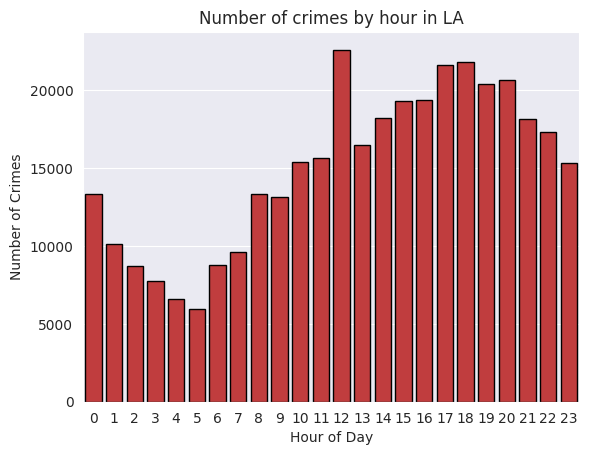

The peak hour crime is 12:00 h


In [ ]:
# Create a countplot of crime by hours
sns.set_style('darkgrid')
sns.countplot(data=crimes,
             x='hour_occurred',
             order=np.arange(0,24),
             color='C3',
             edgecolor='black'
)
plt.xticks(ticks=np.arange(0,24), labels=np.arange(0,24))
plt.title('Number of crimes by hour in LA')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.show()

crimes_by_hour = crimes['hour_occurred'].value_counts()
peak_hour_crime = crimes_by_hour.idxmax()
print(f'The peak hour crime is {peak_hour_crime}:00 h')

### Crime Hour Analysis
- Counted the number of crimes committed at each hour of the day (0–23).
- Visualized the distribution of crimes by hour using **`countplot`** for better clarity with categorical time data.


### Plot Customization
- Adjusted x-axis ticks to show hours from 0 to 23 in chronological order.
- Ensured tick labels were centered in a countplot.

In [ ]:
# Get the most common crimes at noon

crimes_at_noon = crimes.loc[crimes['hour_occurred'] == 12, 'crime_committed']\
                        .value_counts()\
                        .sort_values(ascending=False)

print(crimes_at_noon.head(10))

crime_committed
THEFT OF IDENTITY                                           2571
VEHICLE - STOLEN                                            1970
THEFT PLAIN - PETTY ($950 & UNDER)                          1769
BATTERY - SIMPLE ASSAULT                                    1352
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                    1343
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    1220
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             1168
BURGLARY                                                    1014
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)      974
BURGLARY FROM VEHICLE                                        889
Name: count, dtype: Int64


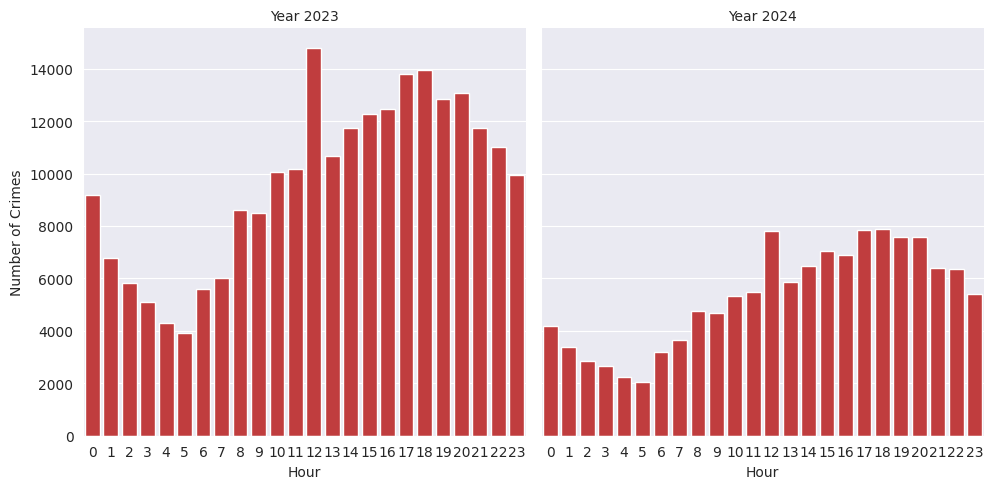

In [ ]:
# Create a 'year' column to use it in a catplot
crimes['year'] = crimes['date_occurred'].dt.year

g = sns.catplot(data=crimes,
            x='hour_occurred',
            order=np.arange(0,24),
            col='year',
            kind='count',
            color='C3'
)
g.set_axis_labels('Hour', 'Number of Crimes')
g.set_titles('Year {col_name}')
g.set(xticks=np.arange(0,24))

### Crime Frequency by Hour – Yearly Comparison

- Created a new column `year` from `date_occurred` using `.dt.year` to extract the year.
- Used **`sns.catplot`** to display separate plots by year (`col='year'`) showing crime frequency by hour (`kind='count'`).
- **Findings:** The hourly crime pattern is almost identical between 2023 and 2024. However, the total number of crimes in 2024 is noticeably lower than in 2023.

year
2023    232339
2024    127561
Name: count, dtype: int64
The total number of crimes decreased by 104778 from 2023 to 2024.
Percentage decrease: 45.10%


Text(0.5, 1.0, 'Number of Crimes in 2023 and 2024')

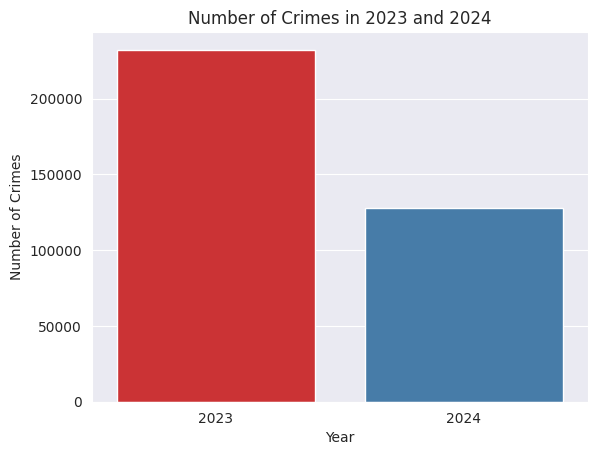

In [ ]:
# Analize the percentage decrease between 2023 and 2024
crimes_by_year = crimes['year'].value_counts().sort_index()
print(crimes_by_year)

difference = crimes_by_year[2023] - crimes_by_year[2024]
percentage_decrease = (difference / crimes_by_year[2023]) * 100
print(f"The total number of crimes decreased by {difference} from 2023 to 2024.")
print(f'Percentage decrease: {percentage_decrease:.2f}%')

sns.countplot(data=crimes,
            x='year',
            hue='year',
            palette='Set1',
            legend=False
)
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Number of Crimes in 2023 and 2024')

## Yearly Crime Comparison (2023 vs 2024)

- Added a **countplot** to visualize the total number of crimes per year, with each bar representing a different year.
- The plot confirms the numerical analysis from previous steps:  
  - The total number of crimes in 2024 is **significantly lower** compared to 2023.
- This visual representation supports the conclusion that there has been a **notable decrease** in reported crimes year-over-year.


crime_committed
VEHICLE - STOLEN                                   45825
SHOPLIFTING - PETTY THEFT ($950 & UNDER)           14210
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)    11365
TRESPASSING                                         6729
BURGLARY                                            5836
                                                   ...  
PURSE SNATCHING - ATTEMPT                              1
THEFT, COIN MACHINE - ATTEMPT                          1
GRAND THEFT / INSURANCE FRAUD                          1
PETTY THEFT - AUTO REPAIR                              1
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE              1
Name: count, Length: 124, dtype: Int64


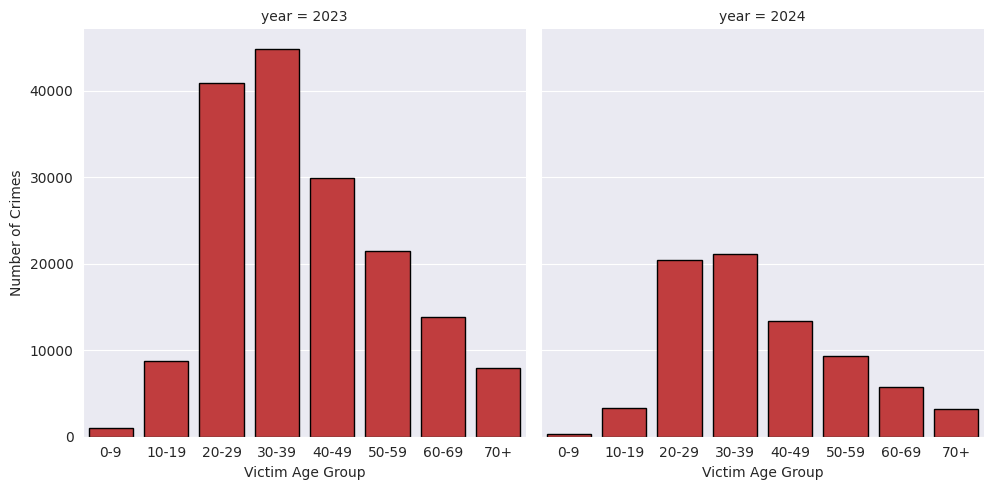

In [ ]:
# Analize the number of crimes by victim's age
groups = [0, 10, 20, 30, 40, 50, 60, 70, 100]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
crimes['age_group'] = pd.cut(crimes['victim_age'],
                            bins=groups,
                            labels=labels,
                            include_lowest=True,
                            right=False
)

vict_zero_age = crimes.loc[crimes['victim_age'] == 0, 'crime_committed']
print(vict_zero_age.value_counts())

sns.catplot(data=crimes[crimes['victim_age'] != 0],
            col='year',
            x='age_group',
            order=labels,
            kind='count',
            color='C3',
            edgecolor='black').set_axis_labels('Victim Age Group', 'Number of Crimes')

###  Analysis of Crimes by Victim's Age (2023 vs 2024)

- Created age groups in 10-year intervals using `pd.cut()` to categorize `victim_age`.
- While analyzing the distribution, the age group **0–9** appeared as the largest, which was suspicious.
- Upon review, discovered that unknown victim ages were recorded as `0`, inflating the 0–9 category.
- To avoid misleading conclusions, we excluded `victim_age == 0` from the plot while keeping these rows in the dataset for potential future analysis.
- After excluding `0`, the 0–9 group became the smallest category, providing a more accurate picture of age distribution.

####  Finding: Victim Age = 0 Analysis

During the age group analysis, the initial results showed that the **0–9 years** category had the highest number of victims.  
Upon further investigation, it was discovered that many records with `victim_age = 0` correspond to crimes where it is highly unlikely that the actual victim was a newborn or infant.  

**Top 3 crimes with `victim_age = 0`:**
1. Vehicle - Stolen → 45,825 cases  

2. Shoplifting - Petty Theft ($950 & Under) → 14,210 cases  

3. Theft from Motor Vehicle - Petty ($950 & Under) → 11,365 cases  

This strongly suggests that `victim_age = 0` is often used as a placeholder for *unknown age*.  
For visualization purposes, these records were excluded from age group plots to avoid misleading interpretations.

In [ ]:
# Count the top 10 crimes committed in each year

crimes_by_year = crimes.groupby(['year', 'crime_committed'])\
                       .size()\
                       .reset_index(name='count')\
                       .sort_values(['year', 'count'], ascending=[True, False])

top10_by_year = crimes_by_year.groupby('year').head(10)

print(top10_by_year)

     year                                    crime_committed  count
129  2023                                   VEHICLE - STOLEN  24471
4    2023                           BATTERY - SIMPLE ASSAULT  18831
19   2023                                           BURGLARY  14289
113  2023                                  THEFT OF IDENTITY  13617
20   2023                              BURGLARY FROM VEHICLE  13565
126  2023  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  13172
2    2023     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  12693
115  2023                 THEFT PLAIN - PETTY ($950 & UNDER)  11462
71   2023                  INTIMATE PARTNER - SIMPLE ASSAULT  10877
102  2023           SHOPLIFTING - PETTY THEFT ($950 & UNDER)  10015
257  2024                                   VEHICLE - STOLEN  21508
151  2024                              BURGLARY FROM VEHICLE   9525
228  2024           SHOPLIFTING - PETTY THEFT ($950 & UNDER)   9056
241  2024                 THEFT PLAIN - PETTY ($

###  Top 10 Most Common Crimes per Year

- Grouped the dataset by `year` and `crime_committed` to count the number of incidents for each crime type.
- Sorted the results in descending order to identify the most frequent crimes.
- Selected the top 10 crimes for each year to focus on the most relevant categories.
- This step helps reveal patterns and shifts in criminal activity between 2023 and 2024.

In [ ]:
# Create a crosstab showing the proportion (%) of each crime type within each year

crimes_by_year_cross = pd.crosstab(
                                   index=crimes['crime_committed'],
                                   columns=crimes['year'],
                                   normalize='columns'
) * 100

crimes_by_year_cross_sorted = crimes_by_year_cross.sort_values(by=[2023, 2024], ascending=[False, False])

crimes_by_year_cross_sorted = crimes_by_year_cross_sorted.round(2)
print(crimes_by_year_cross_sorted)

year                                                 2023   2024
crime_committed                                                 
VEHICLE - STOLEN                                    10.53  16.86
BATTERY - SIMPLE ASSAULT                             8.10   4.23
BURGLARY                                             6.15   3.50
THEFT OF IDENTITY                                    5.86   4.95
BURGLARY FROM VEHICLE                                5.84   7.47
...                                                   ...    ...
FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)   0.00   0.00
PETTY THEFT - AUTO REPAIR                            0.00   0.00
DRUNK ROLL - ATTEMPT                                 0.00   0.00
THEFT, COIN MACHINE - ATTEMPT                        0.00   0.00
TRAIN WRECKING                                       0.00   0.00

[138 rows x 2 columns]


###  Crime Proportions by Year

- Created a crosstab to display the proportion (%) of each crime type within each year using `pd.crosstab()` with `normalize='columns'`.
- Rounded the percentages to two decimal places for clarity.
- This approach allows an easy comparison of how the relative frequency of each crime type changes between 2023 and 2024.
- The data is presented in a long format (crime type as rows, years as columns) for better readability.

In [ ]:
# Count the number of crimes committed by area
crimes_by_area = crimes['area_name'].value_counts().reset_index()
print(crimes_by_area)

# Get the number of crimes committed by area and year
crimes_by_area_year = (
    crimes.groupby(['year', 'area_name'])
    .size()
    .reset_index(name='crime_count')
    .sort_values(['year', 'crime_count'], ascending=[True, False])
    .reset_index(drop=True)
)

print(crimes_by_area_year)

      area_name  count
0       Central  27177
1       Pacific  21953
2     Southwest  21419
3   77th Street  20728
4   N Hollywood  18805
5      Wilshire  18017
6     Hollywood  17600
7       Olympic  17526
8        Newton  17319
9       Rampart  17129
10    Southeast  16897
11      West LA  15999
12     Van Nuys  15699
13   Devonshire  15655
14  West Valley  15217
15      Topanga  15186
16    Northeast  14962
17       Harbor  14442
18      Mission  14341
19   Hollenbeck  12723
20     Foothill  11106
    year    area_name  crime_count
0   2023      Central        16966
1   2023  77th Street        13953
2   2023      Pacific        13792
3   2023    Southwest        13112
4   2023       Newton        11933
5   2023      Olympic        11756
6   2023     Wilshire        11713
7   2023  N Hollywood        11557
8   2023      Rampart        11528
9   2023    Hollywood        11448
10  2023    Southeast        11294
11  2023      West LA        10587
12  2023     Van Nuys         9941
13  

### Crimes by Area (Totals)
- Computed total incidents per `area_name`.
- Outcome: ranked list of areas by absolute crime volume.

### Crimes by Area and Year
- Grouped by `['year', 'area_name']`, counted with `.size()`, named as `crime_count`.
- Sorted by `year` (asc) and `crime_count` (desc) to see the most affected areas each year.
- Applied `.reset_index(drop=True)` to produce a clean, consecutive index after sorting.
- Use case: check whether the **most affected areas** remain the same or shift from 2023 to 2024.

In [ ]:
# Get the most common crime committed in each area
area_crime_count = crimes.groupby(['area_name', 'crime_committed'])\
                         .size()\
                         .reset_index(name='count')

area_crime_count['percentage'] = (
    (
    area_crime_count['count']\
    /area_crime_count.groupby('area_name')['count'].transform('sum')) * 100
).round(2)

most_common_crime_by_area = area_crime_count.loc[area_crime_count.groupby('area_name')\
                                            ['count'].idxmax()]\
                                            .reset_index(drop=True)

print(most_common_crime_by_area)

crimes_in_central = crimes.loc[crimes['area_name'] == 'Central',
                               ['area_name', 'crime_committed']]\
                 .value_counts()

print(crimes_in_central.head(10))



      area_name                           crime_committed  count  percentage
0   77th Street                          VEHICLE - STOLEN   3598       17.36
1       Central                     BURGLARY FROM VEHICLE   3901       14.35
2    Devonshire                          VEHICLE - STOLEN   1449        9.26
3      Foothill                          VEHICLE - STOLEN   1739       15.66
4        Harbor                          VEHICLE - STOLEN   2515       17.41
5    Hollenbeck                          VEHICLE - STOLEN   2267       17.82
6     Hollywood                          VEHICLE - STOLEN   1489        8.46
7       Mission                          VEHICLE - STOLEN   2479       17.29
8   N Hollywood                          VEHICLE - STOLEN   2082       11.07
9        Newton                          VEHICLE - STOLEN   3280       18.94
10    Northeast                          VEHICLE - STOLEN   1934       12.93
11      Olympic                          VEHICLE - STOLEN   2187       12.48

### Most Common Crime by Area (with Percentages)

- Created `area_crime_counts` DataFrame with the total number of crimes per area and crime type.
- Calculated a `percentage` column showing the proportion of each crime type within its area.

- Used groupby('area_name')['count'].idxmax() to get the index of the most frequent crime for each area.

- Applied .loc[] with these indexes to retrieve only the rows with the highest count per area.

Result: Table showing the most common crime in each area along with its absolute count and percentage of total crimes in that area.

#### Insight: Vehicle Theft by Area

- While *Vehicle Stolen* is the most common crime overall, and **Central** is the area with the highest total number of crimes, the most frequent crime in Central is actually **Burglary from Vehicle**.  
- Interestingly, in Central, *Vehicle Stolen* ranks only third in frequency.  
- In absolute numbers, **77th Street** leads in vehicle thefts with **3,598 cases**, representing **17.3%** of all crimes committed there.  
- However, in relative terms, **Newton** has the highest proportion of vehicle thefts: **3,280 cases**, which account for **18.94%** of all crimes in that area.  
- Newton ranks **9th** in total crimes, while 77th Street ranks **4th**.

Text(0, 0.5, ' ')

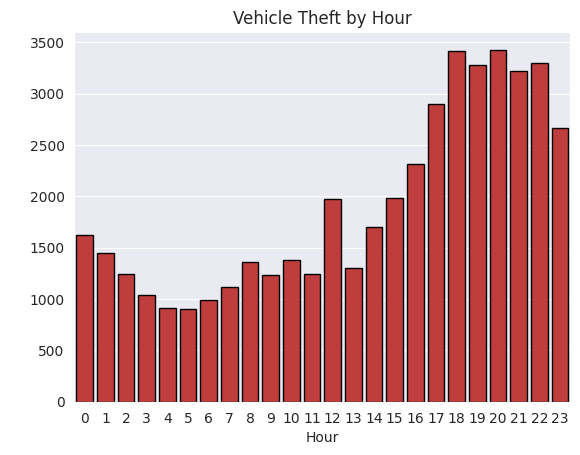

In [ ]:
# Plot the number of vehicles stolen by hour
sns.countplot(data=crimes.loc[crimes['crime_committed'] == 'VEHICLE - STOLEN', :],
              x='hour_occurred',
              color='C3',
              edgecolor='black'
)
plt.title('Vehicle Theft by Hour')
plt.xlabel('Hour')
plt.ylabel(' ')

### Analysis of Vehicle Theft by Hour
- A focused countplot was generated for crimes labeled as *VEHICLE - STOLEN*, grouped by the hour of occurrence.  
- The analysis revealed a notable temporal pattern: vehicle thefts increase significantly after standard working hours, beginning around 17:00, and remain elevated until approximately 22:00.  
- This suggests a post-work vulnerability period where vehicles are more frequently targeted, potentially linked to increased street parking or reduced daylight.

**Caveat / Hypothesis:**  
- It cannot be assumed with certainty that more vehicle thefts actually occur after work hours. The apparent increase might be explained by delayed reporting: victims may not notice their vehicle has been stolen until leaving work, leading to clustering of reports during these hours.

  victim_sex   count
0          M  134948
1          F  119088
2          X  105864


Text(0, 0.5, ' ')

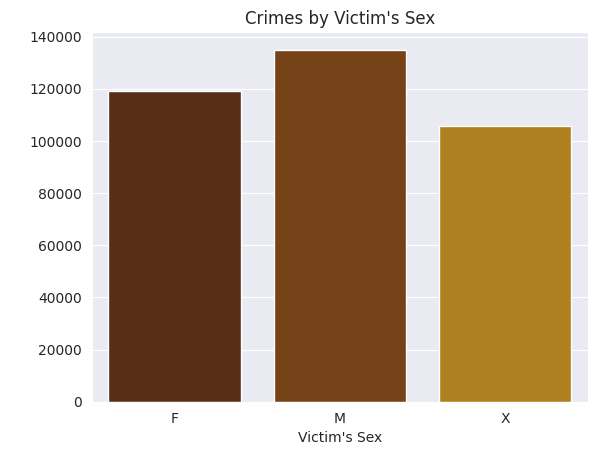

In [ ]:
# Compare and plot the victim's sex

crimes_by_gender = crimes['victim_sex']\
                        .value_counts()\
                        .reset_index(name='count')

print(crimes_by_gender)

palette=["#612c0bff", "#854209", "#c68907"]
sns.countplot(data=crimes,
              x='victim_sex',
              hue='victim_sex',
              legend=False,
              palette=palette
)

plt.title("Crimes by Victim's Sex")
plt.xlabel("Victim's Sex")
plt.ylabel(' ')

### Victim's Sex Analysis

- Men represent the majority of victims with a total of **134,948** crimes committed against them.  
- However, this figure is not far from the **119,088** crimes committed against women.  
- Notably, crimes where the victim's sex is unknown are also significantly numerous (**105,864**).  
- Therefore, we cannot state with complete certainty whether men or women suffer more crimes overall.


victim_descent
X    108712
H     97976
W     67570
B     42217
O     26732
A      7279
K      2569
C      2311
F      2213
J       728
V       558
I       417
Z       269
P       117
U        97
D        46
L        39
G        28
S        22
Name: count, dtype: int64


Text(0, 0.5, ' ')

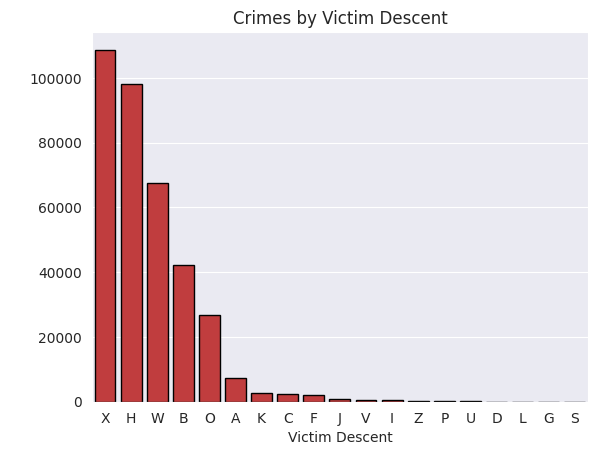

In [ ]:
# Explore the number of crimes by victim's descent

crimes_by_victims_descent = crimes['victim_descent'].value_counts()
print(crimes_by_victims_descent)

sns.countplot(data=crimes,
              x='victim_descent',
              color='C3',
              edgecolor='black',
              order=crimes_by_victims_descent.index
)
plt.title('Crimes by Victim Descent')
plt.xlabel('Victim Descent')
plt.ylabel(' ')

## Victim Descent Analysis
- **Code Interpretation:**
- `X` → Unknown  
- `H` → Hispanic / Latin / Mexican  
- `W` → White  
- `B` → Black  
- `O` → Other  
- (Other codes correspond to less common ethnicities)

- **Insight:**
- The most frequent victim group is **Hispanic/Latin/Mexican**, followed by White and Black.  
- However, it is **not possible to establish a clear victimology pattern** due to two main limitations:  
  1. The category **Unknown (`X`)** represents a very high number of cases, which reduces the reliability of comparisons.  
  2. It would be necessary to **cross these results with population data from Los Angeles** in order to understand the actual victimization rate of each ethnic group.

- **Preliminary Conclusion:**  
Hispanic/Latin/Mexican individuals appear to be the most affected group, but this conclusion must be interpreted cautiously due to the data limitations.

- A further investigation is required

In [ ]:
# Explore the most common crime by victim's age group

crimes_by_victims_age = crimes[crimes['victim_age'] != 0]\
                              .groupby(['age_group', 'crime_committed'])\
                              .size()\
                              .reset_index(name='count')

top_crimes_by_victims_age = (
                            crimes_by_victims_age.loc[
                                crimes_by_victims_age.groupby('age_group')['count'].idxmax(), :]
                            )
print(top_crimes_by_victims_age)

    age_group                          crime_committed  count
24        0-9  CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT    371
136     10-19                 BATTERY - SIMPLE ASSAULT   2237
283     20-29                    BURGLARY FROM VEHICLE   6631
415     30-39                    BURGLARY FROM VEHICLE   7194
532     40-49                 BATTERY - SIMPLE ASSAULT   4116
664     50-59                 BATTERY - SIMPLE ASSAULT   3490
796     60-69                 BATTERY - SIMPLE ASSAULT   2377
942       70+                                 BURGLARY   1522


/tmp/ipython-input-4041676793.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_group', 'crime_committed'])\
/tmp/ipython-input-4041676793.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crimes_by_victims_age.groupby('age_group')['count'].idxmax(), :]


###  Most Common Crimes by Victim's Age Group

**Code Summary:**
- Filtered the dataset to exclude records where the victim's age is `0`, since this value usually indicates that the real age of the victim is unknown.
- Grouped the filtered dataset by:
  - `age_group` → Age ranges previously defined with `pd.cut()`
  - `crime_committed` → Type of crime
- Counted the number of occurrences for each `(age_group, crime_committed)` pair.
- Used `groupby('age_group')['count'].idxmax()` to find the **index** of the most common crime within each age group.
- Used `.loc[]` to retrieve the rows corresponding to those indices.

**Key Insight:**
- When the victim's age is known, **Burglary** and **Battery – Simple Assault** dominate as the most common crimes.
- **Burglary from Vehicle** is the top crime for victims aged **20–39**, while **Battery – Simple Assault** is most frequent in several older age groups.
- **Child Abuse (Physical) – Simple Assault** is the leading crime in the **0–9** age group.

In [ ]:
# Explore the most common crime committed when the victim's age is unknown (0)

top_crime_victim_zero_age = crimes.loc[crimes['victim_age'] == 0, :]\
                                  .groupby('crime_committed')\
                                  .size()\
                                  .reset_index(name='count')\
                                  .sort_values(by='count', ascending=False)

print(top_crime_victim_zero_age.head(5))

                                     crime_committed  count
118                                 VEHICLE - STOLEN  45825
92          SHOPLIFTING - PETTY THEFT ($950 & UNDER)  14210
100  THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)  11365
113                                      TRESPASSING   6729
17                                          BURGLARY   5836


###  Analysis of Crimes with Victim Age = 0

- We filtered the dataset to include only records where the victim's age is **0**, which in this dataset usually indicates that the real age of the victim is unknown.
- We grouped these filtered records by the `crime_committed` column and counted the occurrences for each crime type.
- The **top 5 crimes** when the victim’s age is recorded as `0` are:
  1. **Vehicle - Stolen** → 45,825 cases  

  2. **Shoplifting - Petty Theft ($950 & Under)** → 14,210 cases

  3. **Theft from Motor Vehicle - Petty ($950 & Under)** → 11,365 cases  

  4. **Trespassing** → 6,729 cases  
  
  5. **Burglary** → 5,836 cases  

- **Key insight:** This confirms our earlier suspicion that a significant portion of *Vehicle - Stolen* cases do not have a recorded victim age, likely because the crime does not always involve direct contact with a victim (e.g., theft of an unattended vehicle).

In [ ]:
# Get the top 10 most common crime location type

top_crime_location = crimes.value_counts('location_type_desc')\
                            .reset_index(name='count')\
                            .sort_values('count', ascending=False)

print(top_crime_location.head(10))

                             location_type_desc  count
0                                        STREET  99455
1                        SINGLE FAMILY DWELLING  53316
2  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)  39755
3                                   PARKING LOT  22804
4                                OTHER BUSINESS  18186
5                                      SIDEWALK  12582
6                      VEHICLE, PASSENGER/TRUCK   9568
7                              DEPARTMENT STORE   8773
8                                GARAGE/CARPORT   5955
9                                      DRIVEWAY   4930


###  Top 10 Most Common Crime Locations

**Code Summary:**
- Used `.value_counts()` on `location_type_desc` to count how many crimes occurred at each location type.
- Converted the results into a DataFrame with `.reset_index()`, naming the count column `"count"`.
- Sorted the DataFrame in descending order of crime count.

**Key Insight:**
- **Street** is by far the most common crime location, with almost **double** the incidents of the second place (Single Family Dwelling).
- However, "Street" is a **very broad category**, which could encompass different crime scenarios and contexts.  
  This broad definition limits the specificity of the insight and would require further breakdown or classification for more actionable conclusions.

In [ ]:
# Export the cleaned dataset as a csv

crimes.to_csv('LA crime cleaned.csv', index=False)

## Completion of Python Analysis

The exploratory data analysis (EDA) in Python has been successfully completed.  
The process included univariate and bivariate exploration, grouping, percentage calculations, and the extraction of key insights.  

The next stage of the project will focus on **data visualization and further analysis using Power BI**, taking advantage of its interactive capabilities to explore temporal patterns, variable relationships, and geographical distributions in greater detail.

# Key Insights from Python EDA

- **Temporal Patterns:**  
  - Crime incidents peak at **midday**, a surprising finding given the common assumption that most crimes occur at night.  
  - Vehicle thefts appear to increase after **5 PM**, but this may be influenced by **delayed reporting**—victims often discover the theft after leaving work.  

- **Yearly Trends:**  
  - From 2023 to 2024, total crimes decreased by **45.10%**.  
  - Despite this decline in absolute numbers, **Vehicle Stolen** grew in relative importance, increasing from **10.53% in 2023** to **16.86% in 2024**.  
  - A longer time-series analysis would be necessary to confirm whether crime is consistently decreasing across years.

- **Victim Demographics:**  
  - The age groups **30–39** and **20–29** are the most frequent victims.  
  - When age is known, **Burglary** and **Battery – Simple Assault** dominate as the top crimes, with *Burglary from Vehicle* especially prevalent among victims aged 20–39.  
  - No reliable gender-based victimization pattern can be inferred due to the large number of records with **unknown victim sex**.  
  - Hispanic/Latin/Mexican descent is the most frequent victim group, but high levels of **unknown data** and lack of population benchmarks limit conclusions.

- **Crime Types and Distribution:**  
  - **Vehicle Stolen** remains the single most common crime overall in both years.  
  - Interestingly, in **Central**, the most dangerous area of LA, the top crime is **Burglary from Vehicle**, not Vehicle Stolen.  
  - The **77th Street** area has the highest absolute number of vehicle thefts (3,598 cases), but **Newton** has the highest proportion (18.94% of its total crimes).  

- **Crime Locations:**  
  - **Street** is by far the most common crime location, almost double that of the second category (*Single Family Dwelling*).  
  - However, this category is overly broad and lacks actionable specificity, requiring further breakdown for better insights.

---

## Overall Conclusion
The analysis highlights key crime dynamics in Los Angeles:  
- Midday crime peaks,  
- A sharp drop in overall incidents from 2023 to 2024,  
- Vehicle theft as the most persistent and growing issue,  
- Age 20–39 as the most victimized group,  
- And "Street" as the dominant but vague crime setting.  

While valuable insights emerge, limitations such as **unknown data categories** and the need for **population-adjusted comparisons** suggest that further research is required for more robust conclusions.
